# Pasar imagenes a formato YOLO

# Librerías y configuraciones

In [1]:
!pip install opencv-python

In [90]:
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
import yaml
import json

from glob import glob

# Carga de algunos datos

In [3]:
PATH = '/content/drive/Shareddrives/Detección de polinizadores/Datos/Dataset ArTaxOr - Kaggel '

In [42]:
PATHS_IMAGES = glob(PATH + '/*/*')
ANNOTATIONS_PATHS = glob(PATH + '/*/annotations/*.json')

# Elegir una imagen de ejemplo

In [43]:
ex_image = cv.imread([p for p in PATHS_IMAGES if '7abc276306fa' in p][0])
with open([c for c in ANNOTATIONS_PATHS if '/fffac3dd5b0c7988c2c30b3b103542ec-asset.json' in c][0]) as file:
  ex_annot = json.loads(file.read())

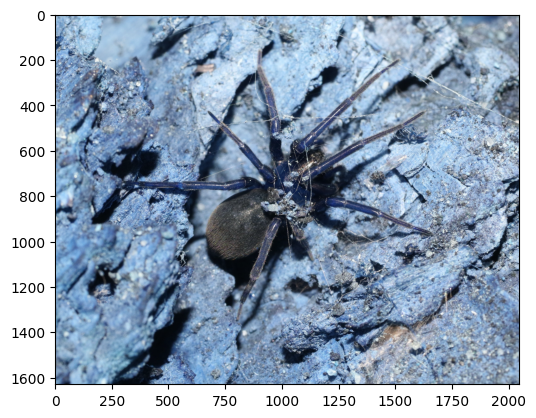

In [44]:
plt.imshow(ex_image)

In [45]:
ex_annot

{'asset': {'format': 'jpg',
  'id': 'fffac3dd5b0c7988c2c30b3b103542ec',
  'name': '7abc276306fa.jpg',
  'path': 'file:F:/ArTaxOr/Araneae/7abc276306fa.jpg',
  'size': {'width': 2048, 'height': 1630},
  'state': 2,
  'type': 1},
 'regions': [{'id': '5vJ5SGfWK',
   'type': 'RECTANGLE',
   'tags': ['Araneae', '_occluded'],
   'boundingBox': {'height': 1205.3256704980843,
    'width': 1390.829268292683,
    'left': 284.6829268292683,
    'top': 151.4463601532567},
   'points': [{'x': 284.6829268292683, 'y': 151.4463601532567},
    {'x': 1675.5121951219512, 'y': 151.4463601532567},
    {'x': 1675.5121951219512, 'y': 1356.772030651341},
    {'x': 284.6829268292683, 'y': 1356.772030651341}]}],
 'version': '2.1.0'}

In [46]:
def dibujar_bounding_box(image, img_annot):
    for region in img_annot['regions']:
        left = int(region['boundingBox']['left'])
        top = int(region['boundingBox']['top'])
        width = int(region['boundingBox']['width'])
        height = int(region['boundingBox']['height'])

        start_point = (left, top)
        end_point = (left + width, top + height)

        color = (255, 0, 0)
        thickness = 3
        cv.rectangle(image, start_point, end_point, color, thickness)

    plt.imshow(image)
    return image

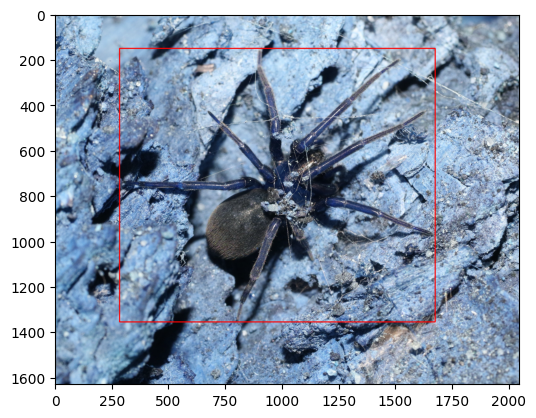

In [47]:
imagen_rectangulo = dibujar_bounding_box(ex_image, ex_annot)

# Conversión de formato a formato YOLO



In [48]:
dict_tags = {'Araneae': 0, 'Coleoptera': 1, 'Diptera': 2, 'Hemiptera': 3, 'Lepidoptera': 4, 'Hymenoptera': 5, 'Odonata': 6}

In [49]:
def bounding_box_to_yolo(bounding_box, width_img, height_img):
  left = bounding_box["left"]
  top = bounding_box["top"]
  box_width = bounding_box["width"]
  box_height = bounding_box["height"]

  x_center = (left + box_width / 2) / width_img
  y_center = (top + box_height / 2) / height_img
  width_norm = box_width / width_img
  height_norm = box_height / height_img

  return x_center, y_center, width_norm, height_norm

def convertir_a_yolo(dict_image):
    width_img = dict_image["asset"]["size"]["width"]
    height_img = dict_image["asset"]["size"]["height"]

    yolo_annotations = []

    for region in dict_image["regions"]:
        tag = region["tags"][0]
        class_id = dict_tags[tag]

        x_center, y_center, width_norm, height_norm = bounding_box_to_yolo(
            region['boundingBox'], width_img, height_img)

        yolo_annotation = f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}"
        yolo_annotations.append(yolo_annotation)

    return yolo_annotations

In [50]:
formato_yolo = convertir_a_yolo(ex_annot)

In [51]:
formato_yolo = [float(c) for c in formato_yolo[0].split(' ')]
formato_yolo

[0.0, 0.478563, 0.462644, 0.679116, 0.739464]

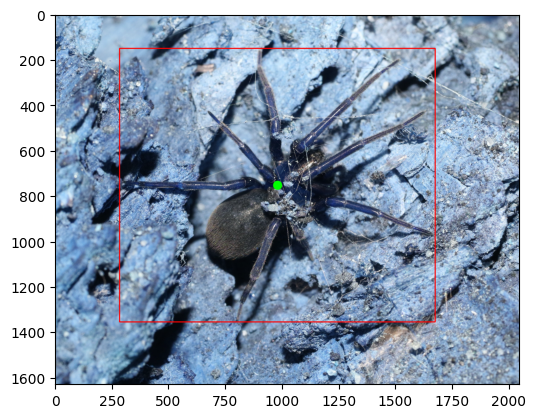

In [52]:
punto = (int(formato_yolo[1]*2048), int(formato_yolo[2]*1630))
plt.imshow(cv.circle(imagen_rectangulo, punto, 20, (0, 255, 0), -1))

# División dataset en train, test y validación

In [60]:
annotations = pd.DataFrame()
annotations['path'] = ANNOTATIONS_PATHS
annotations['category'] = annotations['path'].apply(lambda x: x.split('/')[-3])

In [62]:
train_df, temp_df = train_test_split(annotations, test_size=0.3, random_state=42, stratify=annotations['category'])
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])

[Text(0.5, 1.0, 'Validation')]

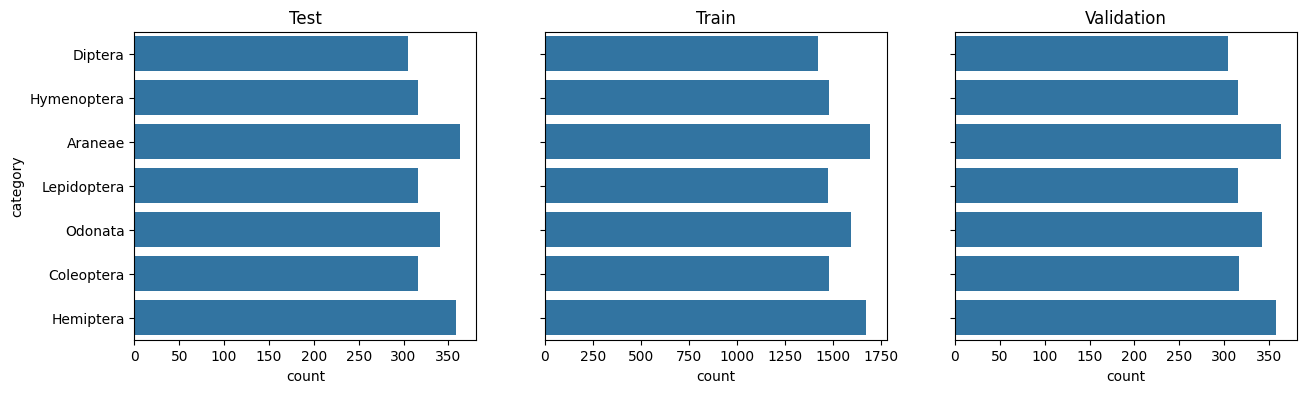

In [70]:
fig, axes = plt.subplots(ncols = 3, figsize = (15,4), sharey = True)
sns.countplot(test_df.category, ax = axes[0]).set(title = 'Test')
sns.countplot(train_df.category, ax = axes[1]).set(title = 'Train')
sns.countplot(val_df.category, ax = axes[2]).set(title = 'Validation')

In [76]:
categorias = train_df['category'].unique()

for categoria in categorias:
    df_categoria = train_df[train_df['category'] == categoria]

    ejemplos = df_categoria['path'].head(3)

    fig, axes = plt.subplots(1, 3, figsize=(3*4, 4))
    fig.suptitle(f'Categoría: {categoria}', fontsize=16)

    for i, annot_path in enumerate(ejemplos):
        with open(annot_path) as file:
          annot = json.loads(file.read())
        name = annot['asset']['name']
        path = [p for p in PATHS_IMAGES if name in p][0]

        img = cv.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Conversión de todo a formato YOLO

In [79]:
!mkdir data
!mkdir data/train data/val data/test
!mkdir data/train/images data/train/labels data/val/images data/val/labels data/test/labels data/test/images

In [94]:
train_df = train_df.iloc[0:int(len(train_df)*0.1)]
test_df = test_df.iloc[0:int(len(test_df)*0.1)]
val_df = val_df.iloc[0:int(len(val_df)*0.1)]

In [99]:
def save_yolo_format_files(df, path_folder):
  for _, row in tqdm(df.iterrows()):
    f_annot = row.path
    with open(f_annot) as file:
      annot = json.loads(file.read())
      name_file = annot['asset']['name'].split('.')[0]
      annot_yolo = convertir_a_yolo(annot)[0]

      # Guardar la anotacion
      with open(f'data/{path_folder}/labels/' + name_file + '.txt', "w") as text_file:
        text_file.write(annot_yolo)

      # Guardar la imagen
      name = annot['asset']['name']
      paths = [p for p in PATHS_IMAGES if name in p]
      if len(paths) > 1:
        print('Revisar ', name, path, f_annot)

      image = cv.imread(paths[0])
      cv.imwrite(f'data/{path_folder}/images/{name_file}.jpg', image)

In [100]:
save_yolo_format_files(train_df, 'train')
save_yolo_format_files(val_df, 'val')
save_yolo_format_files(test_df, 'test')

1080it [01:02, 17.22it/s]
231it [02:55,  1.32it/s]
231it [02:50,  1.35it/s]


# Escribir YAML file

In [101]:
dict_tags

{'Araneae': 0,
 'Coleoptera': 1,
 'Diptera': 2,
 'Hemiptera': 3,
 'Lepidoptera': 4,
 'Hymenoptera': 5,
 'Odonata': 6}

In [102]:
# ----- TODO Revisión de formato
config = {
    'path': '../data/',
    'train': 'train/images',
    'val': 'val/images',
    'names': {
        0: 'Araneae',
        1: 'Coleoptera',
        2: 'Diptera',
        3: 'Hemiptera',
        4: 'Lepidoptera',
        5: 'Hymenoptera',
        6: 'Odonata'
    }
}

In [103]:
# Guardar en un archivo YAML
with open('data/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# Clonar repositorio de Yolo

In [104]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16954, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 16954 (delta 76), reused 95 (delta 45), pack-reused 16805 (from 1)
Receiving objects: 100% (16954/16954), 15.71 MiB | 31.79 MiB/s, done.
Resolving deltas: 100% (11609/11609), done.
/content/yolov5


In [105]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [106]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [107]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [108]:
num_classes = 6

In [109]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train

In [111]:
!cat ../data/config.yaml

names:
  0: Araneae
  1: Coleoptera
  2: Diptera
  3: Hemiptera
  4: Lepidoptera
  5: Hymenoptera
  6: Odonata
path: ../data/
train: train/images
val: val/images


In [112]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 16 --epochs 3 --data '../data/config.yaml' --cfg /content/yolov5/models/custom_yolov5s.yaml --weights '' --name custom_yolov5s_results --cache

/content/yolov5
2024-09-16 23:38:50.733545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 23:38:51.064172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 23:38:51.153031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=/content/yolov5/models/custom_yolov5s.yaml, data=../data/config.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=Fa